In [1]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
# from fbprophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from pytorch_forecasting.metrics import SMAPE
import torch

# Load dataset

In [2]:
ts60 = pd.read_csv('../../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Diff Load Activa Total (60 minuto)'].dropna()
load60.head()


datetime
2020-11-06 00:00:00    2600.0
2020-11-06 01:00:00    2610.0
2020-11-06 02:00:00    2570.0
2020-11-06 03:00:00    2580.0
2020-11-06 04:00:00    2600.0
Name: Diff Load Activa Total (60 minuto), dtype: float64

# Config
Steps for day ahead forecasts are preset to 24 (1 day)

In [3]:
steps = 24
days_ahead = 11

# Train / Test

In [4]:
last_train_day = datetime(2021, 6, 20)
train = load60[:(last_train_day - timedelta(hours=1))]  
train = train.asfreq('H')
test = load60[last_train_day:last_train_day+timedelta(hours=days_ahead*steps-1)]
test = test.asfreq('H')
test
# last_train_day_index = days_ahead * steps
# train = load60.iloc[:-(last_train_day_index)]
# train = train.asfreq('H')
# test = load60[len(train.index):]
# test = test.asfreq('H')


datetime
2021-06-20 00:00:00    2660.0
2021-06-20 01:00:00    2350.0
2021-06-20 02:00:00    2480.0
2021-06-20 03:00:00    2370.0
2021-06-20 04:00:00    2380.0
                        ...  
2021-06-30 19:00:00    1520.0
2021-06-30 20:00:00    1920.0
2021-06-30 21:00:00    1930.0
2021-06-30 22:00:00    2350.0
2021-06-30 23:00:00    2470.0
Freq: H, Name: Diff Load Activa Total (60 minuto), Length: 264, dtype: float64

# Load weather variables

In [5]:
weather = pd.read_csv('../../VEOLIA/artifacts/weather_curated_60min.csv', index_col=0, parse_dates=True)[datetime(2020, 11, 6):]
exog_testing = weather.loc[test.index].values

# Load model from disk

In [6]:
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

sarima = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarima.pkl')
sarimax = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarimax.pkl')
print(sarima.summary())
print(sarimax.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diff Load Activa Total (60 minuto)   No. Observations:                 5424
Model:                 SARIMAX(4, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -38231.968
Date:                                Thu, 29 Jul 2021   AIC                          76479.936
Time:                                        17:08:56   BIC                          76532.688
Sample:                                    11-06-2020   HQIC                         76498.353
                                         - 06-19-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1055      0.051     -2.082      0.037      -0.205      -0.006
ar.

# Day ahead forecast 
## SARIMA

1 day ahead forecast:
MAPE naive: 0.12932806959843607
MAPE: 0.11836845951583158
MSE: 128549.33198527143
RMSE: 358.5377692590718


<Figure size 432x288 with 0 Axes>

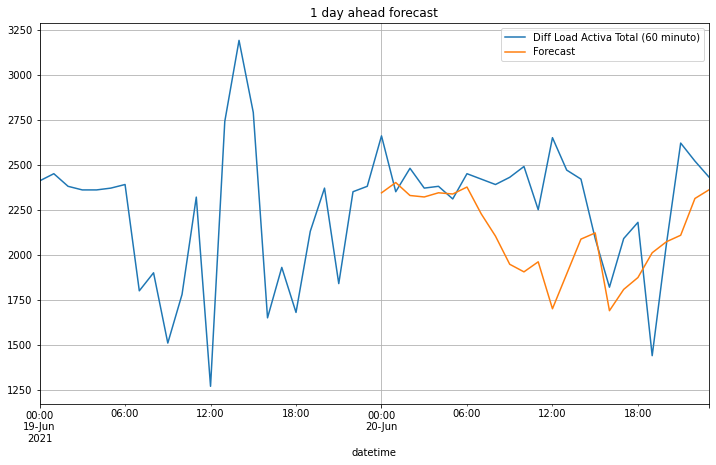

In [7]:
forecast_sarima = sarima.get_forecast(steps=steps)
predictions = forecast_sarima.summary_frame()['mean'].values
ground_truth = test[:steps]

# 1 day ahead forecast evaluation
print("1 day ahead forecast:")
naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

comparison_sarima = pd.DataFrame(ground_truth)
comparison_sarima['Forecast'] = predictions
training = pd.DataFrame(train, columns=comparison_sarima.filter(like='Diff').columns.tolist())
comparison_sarima = pd.concat([training, comparison_sarima])

plt.figure()
plot = comparison_sarima[datetime(2021, 6, 19):].plot(figsize=(12,7), 
                         title="1 day ahead forecast")
plot.grid()

## SARIMAX

1 day ahead forecast:
MAPE naive: 0.12932806959843607
MAPE: 0.09519041029002323
MSE: 74298.0512542809
RMSE: 272.5766887580097


<Figure size 432x288 with 0 Axes>

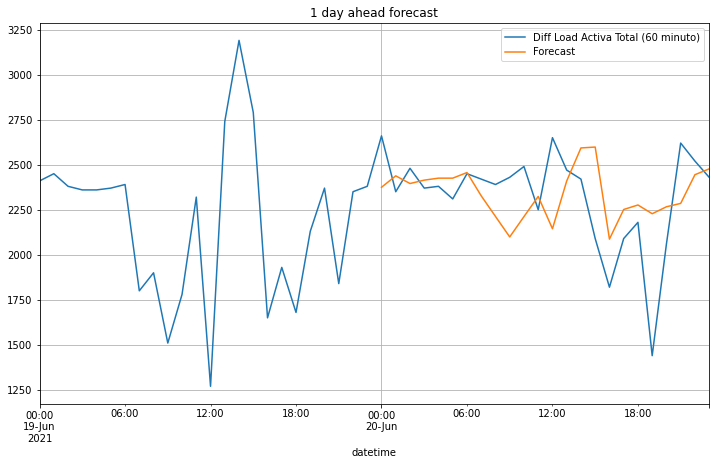

In [8]:
forecast_sarimax = sarimax.get_forecast(steps=steps, exog=exog_testing[:steps])
predictions = forecast_sarimax.summary_frame()['mean'].values
ground_truth = test[:steps]

# 1 day ahead forecast evaluation
print("1 day ahead forecast:")
naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

comparison_sarima = pd.DataFrame(ground_truth)
comparison_sarima['Forecast'] = predictions
training = pd.DataFrame(
    train, columns=comparison_sarima.filter(like='Diff').columns.tolist())
comparison_sarima = pd.concat([training, comparison_sarima])

plt.figure()
plot = comparison_sarima[datetime(2021, 6, 19):].plot(figsize=(12, 7),
                                                      title="1 day ahead forecast")
plot.grid()


Largest improvement is observed here using the ARIMAX model.

# Simple 11-day ahead forecast with error propagation
## SARIMA

Simple 11 day ahead forecast:
MAPE naive: 0.12932806959843607
MAPE: 0.11972988816988364
MSE: 103081.85389998072
RMSE: 321.0636290519073


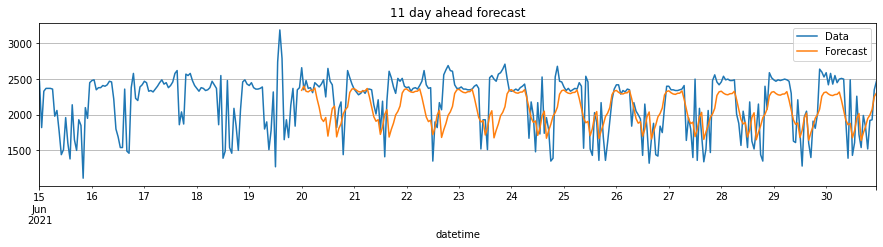

In [9]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarima.forecast(steps * days_ahead)
ground_truth_line = pd.concat([train[-5*24:], test])

naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()


## SARIMAX

Simple 11 day ahead forecast:
MAPE naive: 0.12932806959843607
MAPE: 0.11546437888421016
MSE: 83773.383767353
RMSE: 289.43632074664197


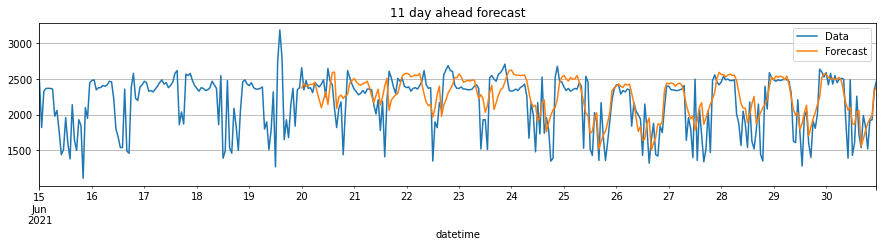

In [10]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarimax.forecast(steps * days_ahead, exog=exog_testing)
ground_truth_line = pd.concat([train[-5*24:], test])

naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(
    15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()


# Advanced 11-day ahead forecast with news update every 24h (no refitting)


Advanced 11 day ahead forecast:
MAPE naive: 0.12932806959843607
SMAPE naive: 0.12687601149082184


MAPE: 0.12683560575512054
SMAPE: 0.12023001164197922
MSE: 100159.56125081856
RMSE: 316.4799539478268


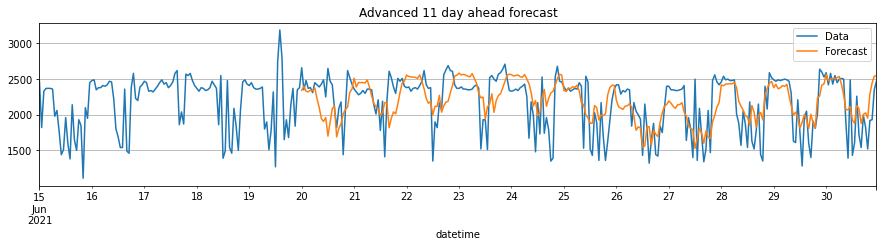

In [11]:
sarima = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarima.pkl')

print(f"Advanced {days_ahead} day ahead forecast:")
ground_truth_line = pd.concat([train[-5 * steps:], test])

predictions = pd.Series(dtype='float64')
for n_day in range(days_ahead):
    cur_timestep = n_day * steps
    next_timestep =  cur_timestep + steps
    day_preds = sarima.forecast(steps)
    predictions = pd.concat([predictions, day_preds])
    y_news = test.iloc[cur_timestep: next_timestep]
    y_news = y_news.asfreq('H')
    sarima = sarima.append(y_news)

predictions.name = test.name
predictions = predictions.rename_axis('datetime')

# Evaluation metrix
naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print(f"SMAPE naive: {SMAPE()(torch.FloatTensor(test).unsqueeze(1), torch.FloatTensor(naive_pred).unsqueeze(1)).item()}")
print("\n================================\n")
print("MAPE:", mape(test, predictions))
print("SMAPE:", SMAPE()(torch.FloatTensor(test).unsqueeze(1), torch.FloatTensor(predictions).unsqueeze(1)).item())
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

# Plot the last 5 days of data and the 11 days of forecast
plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"Advanced {days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()


Not much improvement in comparison to Naive...
In all cases the ARIMA model performs a bit better but close to Naive. However ARIMAX significantly improves the results in all cases
However, statsmodels does not provide news update with exogenous variables so we do not proceed with SARIMAX for the advanced 11-day forecast.